In [1]:
from configobj import ConfigObj
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator
import pyccl as ccl

In [312]:
print(Omg_m)

0.2797409788825341


In [52]:
np.savetxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_reduced',\
           np.array([wc+wb,n_s,A_s,E_dS,f_phi]).T)

# CuGal Simulation

## Run Backend

### Get Power Spectra

In [298]:
## Power spectrum from CCL - with radiation

kk = np.logspace(-3,1,500)*h     # in 1/Mpc


cosmoLCDM = ccl.Cosmology(Omega_c=Omg_m - Omg_b,
                               Omega_b=Omg_b, 
                               A_s=A_s, #2.3429595e-9,
                               h = h,
                               n_s=n_s, #0.953,
                               Omega_k=0)

Pk = ccl.power.linear_matter_power(cosmoLCDM, kk, 1/(1+49))    # in (Mpc)^3


P_k_units = Pk*h**3    # in (Mpc)^3/h^3

kk_units = kk/h    # in h/Mpc

## Save power spectrum for initial conditions (Linear)

np.savetxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid.dat", np.array([kk_units, P_k_units]).T)


In [297]:
## Power spectrum from CCL -without radiation

kk = np.logspace(-3,1,500)*h     # in 1/Mpc


cosmoLCDM = ccl.Cosmology(Omega_c=Omg_m - Omg_b,
                               Omega_b=Omg_b, 
                               A_s=A_s, #2.3429595e-9,
                               h = h,
                               n_s=n_s, #0.953,
                               Omega_k=0)

# Omega_g::: Note that if a non-None value is given, this may result in a physically 
# inconsistent model because the CMB temperature will still be non-zero in the parameters.
cosmoLCDM_norad = ccl.Cosmology(Omega_c=Omg_m - Omg_b,
                               Omega_b=Omg_b, 
                               A_s=A_s, #2.3429595e-9,
                               h = h,
                               n_s=n_s, #0.953,
                               Omega_k=0,
                               Omega_g = 0,
                               T_CMB = 0.0)

Pk_0 = ccl.power.linear_matter_power(cosmoLCDM, kk, 1)    # in (Mpc)^3

Growth_0 = ccl.background.growth_factor(cosmoLCDM_norad, 1)

Growth_49 = ccl.background.growth_factor(cosmoLCDM_norad, 1/(1+49))

print(Growth_49/Growth_0)
print(ccl.background.growth_factor(cosmoLCDM, 1/(1+49)) / ccl.background.growth_factor(cosmoLCDM, 1))
P_k_units_norad = (Growth_49/Growth_0)**2 * Pk_0*h**3    # in (Mpc)^3/h^3

kk_units = kk/h    # in h/Mpc
## Save power spectrum for initial conditions (Linear)

np.savetxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid_backscaled.dat", np.array([kk_units, P_k_units_norad]).T)


0.026096800154296957
0.026330542538800603


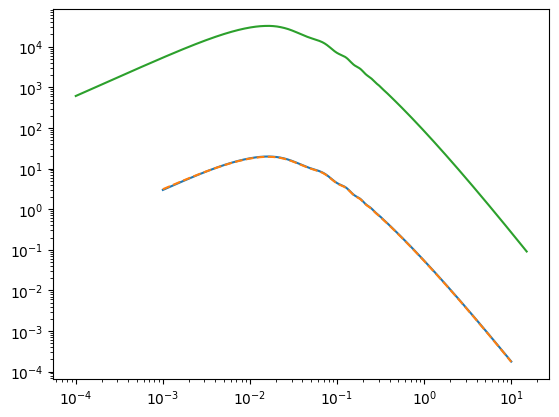

In [295]:
## Plot power spectrum


plt.plot(kk_units,P_k_units)
plt.plot(kk_units,P_k_units_norad, "--")
kk_Georgios, Pk_Georgios = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/LCDM_1306dot3219_matterpower_z0.000.dat").T

plt.plot(kk_Georgios,Pk_Georgios)

plt.xscale("log")
plt.yscale("log")

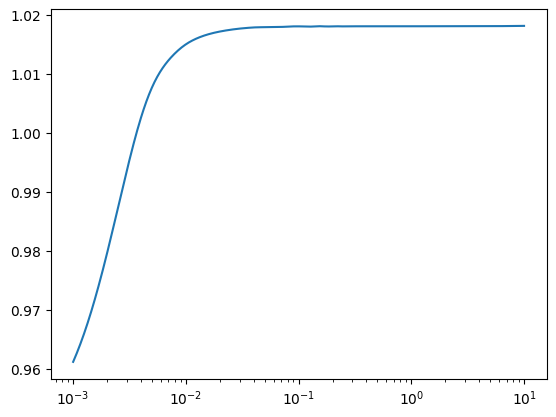

In [296]:
## Plot power spectrum


plt.plot(kk_units,P_k_units/P_k_units_norad)
plt.xscale("log")


### Get expansion and force files

In [247]:
''' Define useful functions'''

def create_params(f, E, h, omegas):
    '''
    Get parameters k, g from f, E and cosmo
    Inputs:
    f --> fphi
    E --> EdS
    omegas --> [b, c, r] * h^2
    
    Outputs:
    k --> k1dS
    g --> g31dS
    '''
    
    # cosmological constant density
    o_DE = h**2 - omegas[0] - omegas[1] - omegas[2]
    O_L = (1-f)*o_DE/ h**2
    
    # k and g
    alpha = 1 - O_L/E**2
    k = -6*alpha
    g = 2*alpha
    
    return k, g

def hypercube_arrays(txt):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    wr = 4.28e-5
    wb = 0.02196
    h = 0.7307
    
    hcube = np.loadtxt(txt).T
    wm = hcube[0]
    n_s = hcube[1]
    A_s = hcube[2]
    E_dS = hcube[3]
    f_phi = hcube[4]
    k1 , g31 = create_params(f_phi, E_dS, h, [wb,wm - wb,wr])
    arr_hor = [f_phi, 1/E_dS, k1, g31]
    arr_num = [h, wr, wb, wm - wb, n_s, A_s]
    
    return arr_hor, arr_num

def Update_ini(run, arr_hor, arr_num, horn_ini, num_ini):
    """
    Updates files num_ini and horn_ini to include the parameters (numerical and MG) from 
    arr_hor = f_phi, H0, k1, g31 and
    arr_num = h , wr , wb , wc, n_s , A_s
    """
    ## Horndeski params
    f_phi, H0, k1, g31 = arr_hor
    h , wr , wb , wc, n_s , A_s = arr_num
    config_h = ConfigObj(horn_ini)
    
    keys_h = config_h.keys()
    
    config_h[keys_h[1]] = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output'
    config_h[keys_h[0]] = 'horndeski_model'
    
    config_h[keys_h[2]] = 'k_1*X'
    config_h[keys_h[3]] = 'g_31*X'
    config_h[keys_h[4]] = '0.5'

    config_h[keys_h[7]] = str(k1)
    config_h[keys_h[8]] = str(g31)
    config_h[keys_h[9]] = str(f_phi)
    config_h[keys_h[10]] = str(H0)    # str(1.085526280345583)
    
    ## Numerical params
    config_n = ConfigObj(num_ini)
    keys_n = config_n.keys()
    
    config_n[keys_n[0]] = 'run_'+str(run)

    
    config_n[keys_n[6]] = str(h)
    config_n[keys_n[7]] = str(wr)
    config_n[keys_n[8]] = str(wb)
    config_n[keys_n[9]] = str(wc)
    config_h.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski.ini'
    config_n.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical.ini'
    config_h.write(); config_n.write()

In [248]:
"""!!!!! CAREFUL WHEN RUNNING THIS deletes a whole directory of frontend parameter files"""
### Run frontend for all different .ini files

## TODO - need to delete the files manually every time
a_h , a_n = hypercube_arrays('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_reduced')

Update_ini(str(0), np.array(a_h).T, np.array(a_n).T, '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_parameters.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_parameters.ini')
command = 'cd ; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski.ini /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical.ini'
os.system(command)


    



Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-6.0, 2.0]
Cosmological parameters-----------
Omega_m0 = 0.2797409788825341
Omega_r0 = 8.016144815327033e-05
Omega_lambda0 = 0.0
Initial conditions----------------
Hubble0 = 1.0857763300760044
scalar_prime0 = 0.9
Closure parameter is phiprime = 0.8484372511237896
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
 expansion: /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_0_expansion_3.txt 
 force:/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files

0

In [9]:
# Create cola folders - only need to do this once
"""
for i in range(len(np.array(a_h).T)):
    # CAREFUL!! might not need this next step
    command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}'.format(str(i))
    os.system(command)
    os.system("cd; cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/; mkdir COLA_{}".format(str(i)))
"""

## Run Frontend

In [300]:
def rewriteluafile(k,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """
    wr = 4.28e-5
    wb = 0.02196
    h = 0.7307
    
    hcube = np.loadtxt(txt).T
    wm = hcube[0]
    n_s = hcube[1]
    A_s = hcube[2]
    E_dS = hcube[3]
    f_phi = hcube[4]

    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)

    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Hi-COLA_params_emu_{}.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}_norad"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 63:
            c.write('  HiCOLA_expansion_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_expansion.txt"'.format(str(k))+'\n')
        elif i== 100:
            c.write('  HiCOLA_preforce_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_force.txt"'.format(str(k))+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {20}'+'\n')        
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid_backscaled.dat"'+'\n')
        elif i== 271:
            c.write('ic_input_redshift = 49.0'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()

txt = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_reduced"


In [301]:
"""Re-write lua file"""
rewriteluafile(0,txt,400,512,512)


In [302]:
"""Create Pk"""

os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Hi-COLA_params_emu_0.lua")
    


#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

# GR Simulation

## Run Frontend

In [254]:
def rewriteluafile(k,txt,boxsize,n_particles,n_mesh):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi) for all k
    For a certain backend file number (a certain k) it creates a lua file that makes HiCOLA output in a separate folder
    """
    wr = 4.28e-5
    wb = 0.02196
    h = 0.7307
    
    hcube = np.loadtxt(txt).T
    wm = hcube[0]
    n_s = hcube[1]
    A_s = hcube[2]
    E_dS = 1.0
    f_phi = 0.0

    # Derived params
    Omg_r = wr/h**2
    Omg_m = wm/h**2
    Omg_b = wb/h**2
    Omg_Lambda = (1-f_phi)*(1-Omg_m-Omg_r)
    Omg_DE = (1-Omg_m-Omg_r)

    a= open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Hi-COLA_params_emu.lua','r')
    b = a.readlines()
    c = open('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Hi-COLA_params_emu_{}_GR.lua'.format(str(k)),'w')
    for i in range(len(b)):
        if i==19:
            c.write('simulation_name = "my_new_Hi-COLA_simulation_{}_GR"'.format(str(k))+'\n')
        elif i==21:
            c.write('simulation_boxsize = '+str(boxsize)+'\n')
        elif i==38:
            c.write('cosmology_model = "LCDM"'+'\n')
        elif i== 40:
            c.write('cosmology_OmegaCDM = '+str((wm-wb)/h**2)+'\n')
        elif i== 42:
            c.write('cosmology_Omegab = '+str(wb/h**2)+'\n')
        elif i== 46:
            c.write('cosmology_OmegaLambda = '+str(Omg_DE)+'\n')
        elif i== 52:
            c.write('cosmology_h = '+str(h)+'\n')
        elif i== 54:
            c.write('cosmology_As = '+str(A_s)+'\n')
        elif i== 56:
            c.write('cosmology_ns = '+str(n_s)+'\n')
        elif i== 95:
            c.write('gravity_model = "GR"'+'\n')
        elif i== 208:
            c.write('particle_Npart_1D = '+str(n_particles)+'\n')
        elif i== 210:
            c.write('particle_allocation_factor = '+str(2.0)+'\n')
        elif i== 222:
            c.write('output_folder = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}"'.format(str(k))+'\n')
        elif i== 229:
            c.write('timestep_nsteps = {20}'+'\n')   
        elif i== 269:
            c.write('ic_input_filename = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/P_k_z/Pk_lin_z49_LCDM_fid.dat"'+'\n')
        elif i== 312:
            c.write('force_nmesh = '+str(n_mesh)+'\n')
        elif i== 345:
            c.write('pofk_nmesh = '+str(n_mesh)+'\n')
        #elif i== 359:
        #    c.write('pofk_multipole_nmesh = '+str(n_mesh)+'\n')
        #elif i== 375:
        #    c.write('bispectrum_nmesh = '+str(n_mesh)+'\n')
        else:
            c.write(b[i])

    c.close()
    a.close()

txt = "/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_reduced"


In [255]:
"""Re-write lua file"""
rewriteluafile(0,txt,400,512,512)


In [182]:
os.system("cd; cd /home/c2042999/HiCOLA_env/Hi-COLA/HiCOLA/FML/COLASolver; mpirun -np 32 nbody /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/luafiles/Hi-COLA_params_emu_0_GR.lua")




#=====================================================
#           ________________  .____         
#           \_   _____/     \ |    |      
#            |    __)/  \ /  \|    |      
#            |     \/    Y    \    |___   
#            \___  /\____|__  /_______ \ 
#                \/         \/        \/ 
#
# Initializing FML, MPI and FFTW
# MPI is enabled. Running with 32 MPI tasks
# OpenMP is enabled. Main task has 40 threads availiable
# MPI + Threads is working
# FFTW is enabled. Thread support is enabled
#
# List of tasks:
# Task    0 [pulsar-cn-3]
#     x-domain [       0 ,  0.03125)
# Task    1 [pulsar-cn-3]
#     x-domain [ 0.03125 ,   0.0625)
# Task    2 [pulsar-cn-3]
#     x-domain [  0.0625 ,  0.09375)
# Task    3 [pulsar-cn-3]
#     x-domain [ 0.09375 ,    0.125)
# Task    4 [pulsar-cn-3]
#     x-domain [   0.125 ,  0.15625)
# Task    5 [pulsar-cn-3]
#     x-domain [ 0.15625 ,   0.1875)
# Task    6 [pulsar-cn-3]
#     x-domain [  0.1875 ,  0.21875)
# Task    7 [pulsa

0

# Comparison Plots

Text(0, 0.5, '$E^{CuGal}/E^{\\Lambda CDM}$')

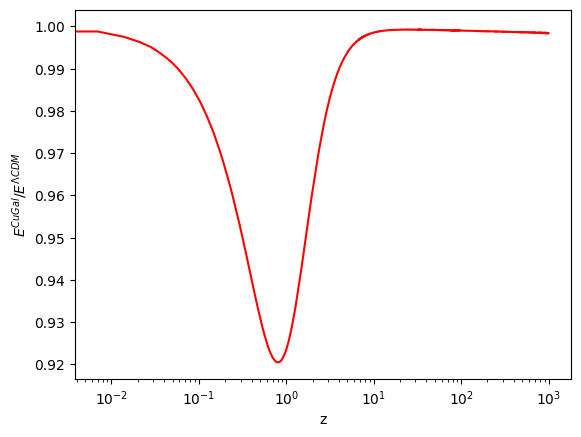

In [265]:
## Plotting ##

fig, axs = plt.subplots(1)
expansioni = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_0_expansion.txt")

expansionPap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/Galdat_f1p0_EdS_max_expansion.txt")


a = expansioni.T[0]
E_a = expansioni.T[1]

a_Pap = expansionPap.T[0]
E_a_Pap = expansionPap.T[1]

E_a_GR = np.sqrt((wb+wc)*a**(-3) + wr*a**(-4) + (h**2 - (wb+wc) -wr))/h
plt.plot(1/a -1, E_a_Pap/E_a_GR, alpha=1, color="r")
#plt.plot(1/a -1, E_a/E_a_Pap, "k--", alpha=1)


plt.xscale("log")

plt.xlabel("z")
plt.ylabel(r"$E^{CuGal}/E^{\Lambda CDM}$")


Text(0, 0.5, '$E^{CuGal}/E^{\\Lambda CDM}$')

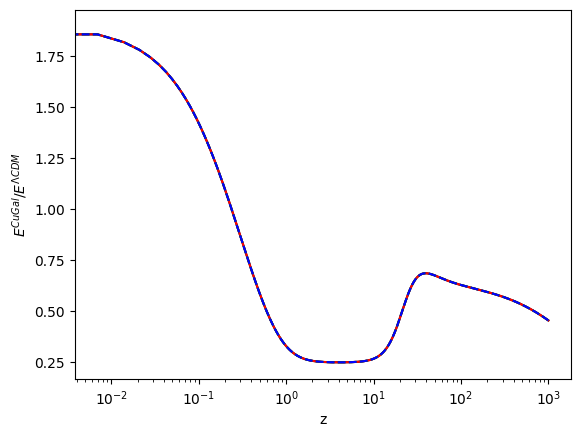

In [266]:
## Plotting ##

fig, axs = plt.subplots(1)
force = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_0_force.txt")
#force_new = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_0_force_2.txt")

forcePap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/Galdat_f1p0_EdS_max_screencoupl.txt")
forcePap1 = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/cG-f1.0_force.txt")

#force_new = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/cuGal_f1p0_WMAP_force.txt")

a = force.T[0]
chiD = force.T[1]
coupling = force.T[2]

aPap = forcePap.T[0]
chiDPap = forcePap.T[1]
couplingPap = forcePap.T[2]

aPap1 = forcePap1.T[0]
chiDPap1 = forcePap1.T[1]
couplingPap1 = forcePap1.T[2]

aPap_new = force_new.T[0]
chiDPap_new = force_new.T[1]
couplingPap_new = force_new.T[2]

plt.plot(1/a -1, chiD, alpha=1, color="k")
plt.plot(1/a -1, chiDPap, alpha=1, color="r")
plt.plot(1/a -1, chiDPap1, "g--",alpha=1)
plt.plot(1/a -1, chiDPap_new, "b--",alpha=1)
#plt.plot(1/a -1, couplingPap, alpha=1, color="k")
#plt.plot(1/a -1, coupling-couplingPap, "r--", alpha=1)


plt.xscale("log")

plt.xlabel("z")
plt.ylabel(r"$E^{CuGal}/E^{\Lambda CDM}$")


Text(0, 0.5, '$B(k)$ ')

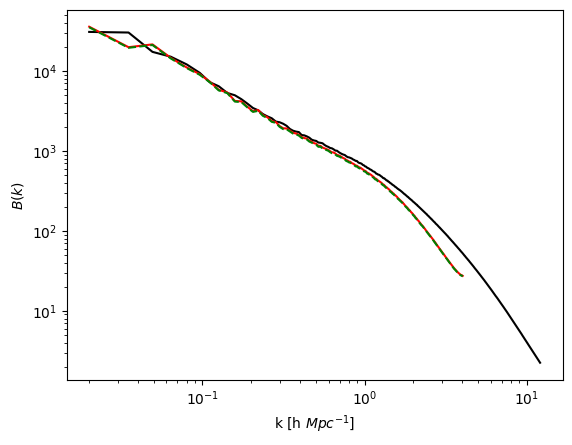

In [303]:
"""Plotting the Boost for the simulations at z = 0"""


k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/pofk_my_new_Hi-COLA_simulation_0_cb_z0.000.txt").T
k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb_z0.000.txt").T

k, Pk_NL_norad,Pk_Lin_norad = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/pofk_my_new_Hi-COLA_simulation_0_norad_cb_z0.000.txt").T

#k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/snapshot_my_new_Hi-COLA_simulation_0_z0.000/pofk_z0.000.txt").T


k_pap, Pk_NL_pap,Pk_Lin_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_cuGal_fphi1p0_z-0.002.txt").T
k_pap, Pk_NL_GR_pap,Pk_Lin_GR_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_GR-LCDM_z-0.002.txt").T


#plt.plot(k,Pk_NL/Pk_NL_GR)
#plt.plot(k_pap,Pk_NL_pap/Pk_NL_GR_pap)

#plt.plot(k,Pk_NL_GR, "g")
#plt.plot(k_pap,Pk_NL_GR_pap)

plt.plot(k_pap,Pk_NL_pap, "k")

plt.plot(k,Pk_NL, "r")
plt.plot(k,Pk_NL_norad, "g--")

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$B(k)$ ")

Text(0, 0.5, '$B(k)$ ')

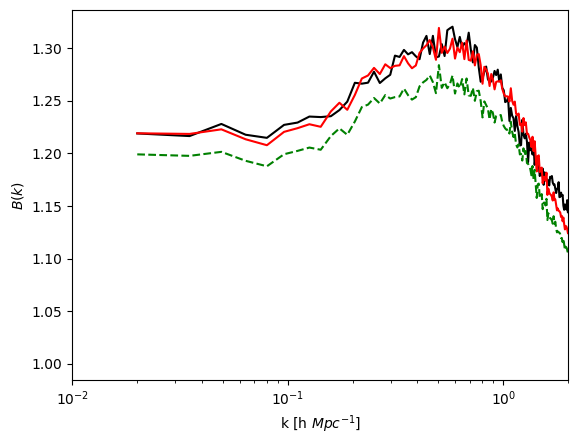

In [304]:
# Plotting boosts


plt.plot(k_pap,Pk_NL_pap/Pk_NL_GR_pap, "k")

plt.plot(k,Pk_NL/Pk_NL_GR, "r")
plt.plot(k,Pk_NL_norad/Pk_NL_GR, "g--")


plt.xscale("log")
plt.xlim(1e-2,2)
plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$B(k)$ ")

Text(0, 0.5, 'ratio ')

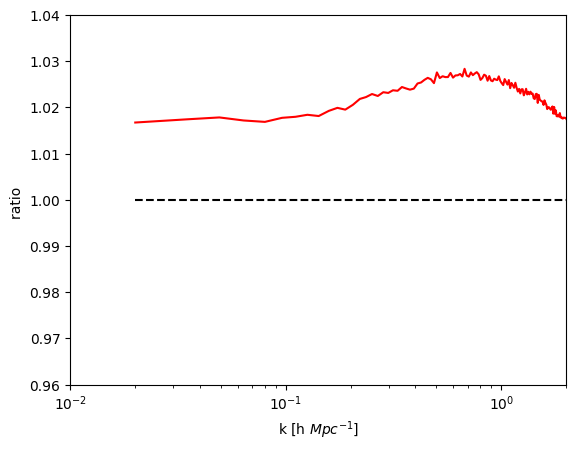

In [311]:
# Plotting boost ratios = Pk ratios with and without radiation effects


plt.plot(k,(Pk_NL)/(Pk_NL_norad), "r")

plt.plot(k,np.ones(len(k)), "k--")

plt.xscale("log")
plt.xlim(1e-2,2)
plt.ylim(0.96,1.04)

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("ratio ")

Text(0, 0.5, '$B(k)$ ')

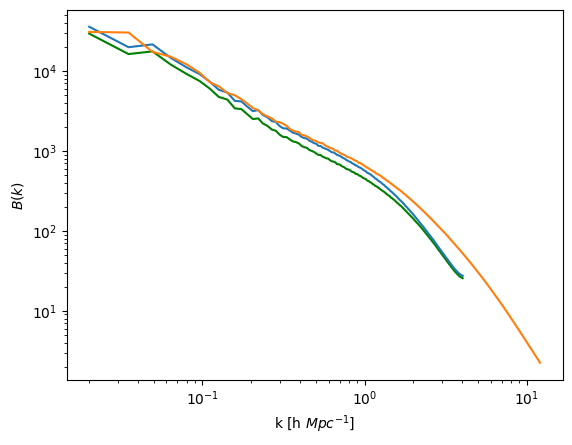

In [279]:
"""Plotting the Boost for the simulations at z = 0"""


k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/pofk_my_new_Hi-COLA_simulation_0_cb_z0.000.txt").T
k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb_z0.000.txt").T

#k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/snapshot_my_new_Hi-COLA_simulation_0_z0.000/pofk_z0.000.txt").T


k_pap, Pk_NL_pap,Pk_Lin_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_cuGal_fphi1p0_z-0.002.txt").T
k_pap, Pk_NL_GR_pap,Pk_Lin_GR_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_GR-LCDM_z-0.002.txt").T


#plt.plot(k,Pk_NL/Pk_NL_GR)
#plt.plot(k_pap,Pk_NL_pap/Pk_NL_GR_pap)

plt.plot(k,Pk_NL_GR, "g")
#plt.plot(k_pap,Pk_NL_GR_pap)


plt.plot(k,Pk_NL)
plt.plot(k_pap,Pk_NL_pap)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$B(k)$ ")

Text(0, 0.5, '$P(k)$ ')

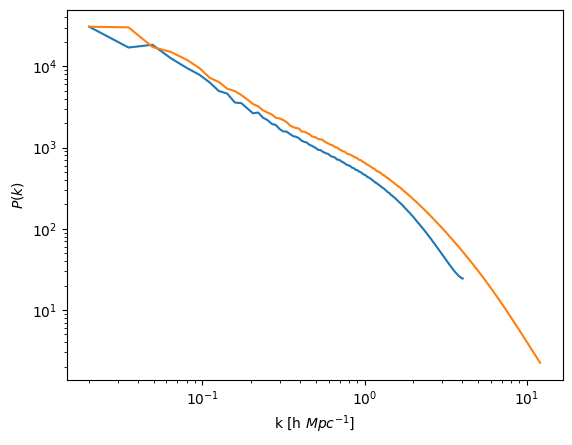

In [242]:
"""Plotting the Boost for the simulations at z = 0"""


k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/pofk_my_new_Hi-COLA_simulation_0_cb_z0.000.txt").T
k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb_z0.000.txt").T

#k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/snapshot_my_new_Hi-COLA_simulation_0_z0.000/pofk_z0.000.txt").T


k_pap, Pk_NL_pap,Pk_Lin_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_cuGal_fphi1p0_z-0.002.txt").T
k_pap, Pk_NL_GR_pap,Pk_Lin_GR_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_GR-LCDM_z-0.002.txt").T

# Ashim re-running same things
k_ACode, Pk_NL_ACode,Pk_Lin_ACode = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_cuGal_bgCarola_icCCL_cb_z0.000.txt").T
k_ACode, Pk_NL_GR_ACode,Pk_Lin_GR_ACode = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_LCDM_bgFML_icCCL_cb_z0.000.txt").T


#plt.plot(k,Pk_NL/Pk_NL_GR)
#plt.plot(k_pap,Pk_NL_pap/Pk_NL_GR_pap)

#plt.plot(k,Pk_NL_GR, "g")
#plt.plot(k,Pk_NL_GR_ACode, "r--")
#plt.plot(k_pap,Pk_NL_GR_pap)


plt.plot(k,Pk_NL)
plt.plot(k_pap,Pk_NL_pap)

#plt.plot(k_pap,Pk_NL_pap)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P(k)$ ")

Text(0, 0.5, '$P(k)$ ')

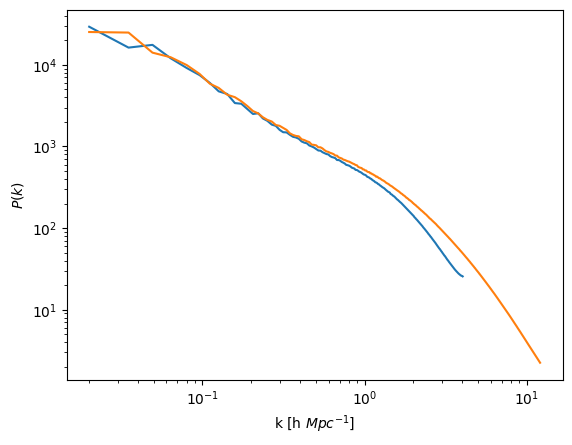

In [189]:
"""Plotting the Boost for the simulations at z = 0"""


k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/pofk_my_new_Hi-COLA_simulation_0_cb_z0.000.txt").T
k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb_z0.000.txt").T

#k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/snapshot_my_new_Hi-COLA_simulation_0_z0.000/pofk_z0.000.txt").T


k_pap, Pk_NL_pap,Pk_Lin_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_cuGal_fphi1p0_z-0.002.txt").T
k_pap, Pk_NL_GR_pap,Pk_Lin_GR_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_GR-LCDM_z-0.002.txt").T


#plt.plot(k,Pk_NL/Pk_NL_GR)
#plt.plot(k_pap,Pk_NL_pap/Pk_NL_GR_pap)

plt.plot(k,Pk_NL_GR)
plt.plot(k_pap,Pk_NL_GR_pap)


#plt.plot(k,Pk_NL)
#plt.plot(k_pap,Pk_NL_pap)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P(k)$ ")

Text(0, 0.5, '$B(k)$ ')

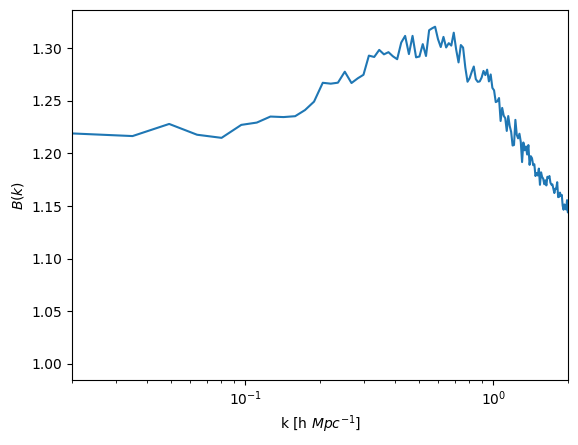

In [177]:
"""Plotting the Boost for the simulations at z = 0"""


k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/pofk_my_new_Hi-COLA_simulation_0_cb_z0.000.txt").T
k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb_z0.000.txt").T

#k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/snapshot_my_new_Hi-COLA_simulation_0_z0.000/pofk_z0.000.txt").T


k_pap, Pk_NL_pap,Pk_Lin_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_cuGal_fphi1p0_z-0.002.txt").T
k_pap, Pk_NL_GR_pap,Pk_Lin_GR_pap = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Ashim_files/pofk_GR-LCDM_z-0.002.txt").T


#plt.plot(k,Pk_NL/Pk_NL_GR)
#plt.plot(k_pap,Pk_NL_pap/Pk_NL_GR_pap)

#plt.plot(k,Pk_NL_GR)
#plt.plot(k_pap,Pk_NL_GR_pap)


plt.plot(k,Pk_NL_pap/Pk_NL_GR_pap)

plt.xscale("log")
plt.xlim(1e-2,2)
plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$B(k)$ ")

In [128]:
Pk_nl =ccl.nonlin_matter_power(cosmoLCDM, k*h, 1)

Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

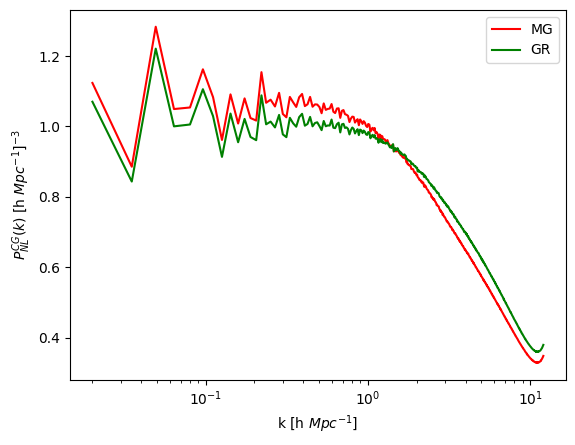

In [129]:
"""Plotting the NL power spectra for the simulations at z = 0"""


k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0/pofk_my_new_Hi-COLA_simulation_0_cb_z0.000.txt").T
k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_0_GR/pofk_my_new_Hi-COLA_simulation_0_GR_cb_z0.000.txt").T

#plt.plot(k,Pk_NL, "r", label = "MG")
#plt.plot(k,Pk_NL_GR, "g", label = "GR")
#plt.plot(kk/h,Pk_nl*h**3, "k--", label = "GR, ccl")


plt.plot(k,Pk_NL/(Pk_nl*h**3), "r", label = "MG")
plt.plot(k,Pk_NL_GR/(Pk_nl*h**3), "g", label = "GR")

#plt.plot(k,Pk_NL/Pk_nl, label = "CuGal")
plt.xscale("log")
#plt.yscale("log")
plt.legend()

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")